In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import glob
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold, KFold
import optuna
from optuna.visualization import plot_param_importances
import matplotlib.pyplot as plt

device = torch.device('cuda')
torch.cuda.empty_cache()

In [2]:
path_train = 'train'
path_test = 'test'
filenames_train = glob.glob(path_train + "/*.csv")
data_files_train = []

for filename in filenames_train:
    data_files_train.append(pd.read_csv(filename))

data_train = pd.concat(data_files_train, ignore_index=True)

filenames_test = glob.glob(path_test + "/*.csv")

data_files_test = []

for filename in filenames_test:
    data_files_test.append(pd.read_csv(filename))

data_test = pd.concat(data_files_test, ignore_index=True)
ids = data_test['id']

X_train = data_train.drop(['target', 'smpl', 'id'], axis=1)
y_train = data_train['target']
cat_features = set(['feature_3', 'feature_10', 'feature_12', 'feature_14', 'feature_15', 'feature_17', 'feature_20', 'feature_21', 'feature_23', 'feature_54', 'feature_60', 'feature_70', 'feature_92', 'feature_98', 'feature_101', 'feature_126', 'feature_135', 'feature_137', 'feature_142', 'feature_153', 'feature_179', 'feature_187', 'feature_198', 'feature_242', 'feature_244', 'feature_255', 'feature_270', 'feature_312', 'feature_330', 'feature_339', 'feature_341', 'feature_342', 'feature_372', 'feature_375', 'feature_383', 'feature_396', 'feature_411'])


features = X_train.columns
idx = {}

for i, feature in enumerate(features):
    if feature in cat_features:
        idx[i] = 0

for i, feature in enumerate(features):
    if i in idx.keys():
        idx[i] = len(set(X_train[feature]))

X_test = data_test.drop(['smpl'], axis=1)

In [3]:
def prepare_cat_features(data: pd.DataFrame, cat_features: list) -> pd.DataFrame:
    """
    Преобразует категориальные признаки в целые числа или строки для CatBoost
    
    Args:
        data: исходный датафрейм
        cat_features: список категориальных признаков
    
    Returns:
        DataFrame с преобразованными категориальными признаками
    """
    result = data.copy()
    
    for feature in cat_features:
        if result[feature].dtype == float:
            if result[feature].apply(lambda x: x.is_integer()).all():
                result[feature] = result[feature].astype(int)
            else:
                result[feature] = result[feature].astype(str)
        elif result[feature].dtype != int:
            result[feature] = result[feature].astype(str)
            
    return result
X_train = prepare_cat_features(X_train, cat_features)
X_test = prepare_cat_features(X_test, cat_features)

In [5]:
X_train.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,0.468142,-1.045346,0,0.384487,0.435121,-1.178548,0.124543,1.801544,0.332028,0,...,-0.361507,-1.026853,0,1.418600,-0.929668,1.284014,0.731842,0.801786,-0.728297,-0.412095
1,-0.760983,0.515132,0,-1.673905,-0.393862,-1.584207,-0.439778,0.796104,-1.331832,0,...,-0.546275,-1.489542,0,-0.622007,-0.473156,0.780020,0.648577,0.646100,-0.789362,0.083349
2,1.658855,0.915052,0,-0.581082,0.477199,-0.622226,0.390642,0.753299,0.400727,0,...,-0.485999,0.586012,0,0.361481,-0.364566,-1.318596,-0.385155,0.140133,0.123245,-0.670030
3,-0.638854,0.314099,0,0.000919,1.102342,-0.807371,0.329158,0.484305,0.412519,1,...,0.321985,-0.075827,0,-1.629672,0.876864,0.411271,0.433440,0.997364,2.829590,-1.275588
4,-1.091376,0.859811,0,-0.505439,1.665086,-0.912464,-0.332054,0.707705,-1.534071,0,...,0.828886,0.140387,0,-0.624304,-2.197691,-1.479267,-0.465917,-0.014757,-0.320434,-0.511896


In [6]:
X_test.head()

,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_409,feature_410,feature_411,feature_412,feature_413,feature_414,feature_415,feature_416,feature_417,feature_418
0,38731,0.262983,-1.153775,1,-0.648932,-0.847237,-0.462393,-1.215373,0.605520,-0.080070,...,-0.236218,-1.058259,0,0.835147,-0.176562,-1.455333,-0.766280,-1.365915,0.454763,0.809724
1,38732,-0.698407,-1.529096,1,0.033011,-1.166594,-0.889886,-0.900391,-1.201925,-0.921064,...,-1.157688,0.334938,0,-0.231860,-0.080340,-0.493846,-1.245681,-1.632521,0.246708,-0.226893
2,38733,-0.331403,-0.538437,1,-1.531462,-0.924031,-1.062342,-1.789274,-1.097902,1.447598,...,-1.159555,0.351526,0,-1.375061,-0.156735,-0.437773,-1.851818,0.984694,0.630962,0.279446
3,38734,0.675162,-0.077064,1,-1.893065,0.610631,-1.404934,-2.650392,-1.752463,-0.833992,...,0.180918,0.269593,0,1.054666,-0.219652,-0.438285,-0.707442,-1.498935,0.962498,-0.390251
4,38735,-2.162385,-1.737901,1,-1.899384,-1.384151,0.106314,-0.814678,1.111808,-1.107233,...,0.696544,1.006378,0,1.107787,-0.282357,-0.235000,-1.794316,-0.504509,-0.385182,-1.130777


In [10]:
!pip3 install lightgbm --upgrade

In [11]:
!pip3 install xgboost --upgrade

In [12]:
!pip3 install catboost --upgrade

   ---------------------------------------- 0.0/101.8 MB ? eta -:--:--
    --------------------------------------- 1.8/101.8 MB 11.2 MB/s eta 0:00:09
   - -------------------------------------- 3.1/101.8 MB 11.5 MB/s eta 0:00:09
   -- ------------------------------------- 5.2/101.8 MB 10.3 MB/s eta 0:00:10
   -- ------------------------------------- 7.3/101.8 MB 9.8 MB/s eta 0:00:10
   --- ------------------------------------ 9.4/101.8 MB 9.8 MB/s eta 0:00:10
   ---- ----------------------------------- 11.5/101.8 MB 9.7 MB/s eta 0:00:10
   ----- ---------------------------------- 13.1/101.8 MB 9.3 MB/s eta 0:00:10
   ------ --------------------------------- 15.7/101.8 MB 10.2 MB/s eta 0:00:09
   ------- -------------------------------- 17.8/101.8 MB 10.2 MB/s eta 0:00:09
   ------- -------------------------------- 18.9/101.8 MB 10.1 MB/s eta 0:00:09
   ------- -------------------------------- 18.9/101.8 MB 10.1 MB/s eta 0:00:09
   ------- -------------------------------- 18.9/101.8 MB 

In [4]:
X, X_eval, y, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

X.shape, X_eval.shape, y.shape, y_eval.shape

((30984, 418), (7747, 418), (30984,), (7747,))

# Catboost hyperparameters tuning

In [16]:
import catboost as cb

In [30]:
def objective(trial):
    n_iterations = trial.suggest_int('n_iterations', 100, 1500)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2)
    depth = trial.suggest_int('depth', 3, 10)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.001, 10)
    temperatures = trial.suggest_float('temperatures', 0.001, 10)

    model = cb.CatBoostClassifier(
        iterations=n_iterations,
        cat_features=list(cat_features),
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=temperatures,
        auto_class_weights='Balanced',
        random_seed=42,
        eval_metric='AUC',
        verbose=False,
    )
    model.fit(X, y, eval_set=(X_eval, y_eval), early_stopping_rounds=200)
    return model.best_score_['validation']['AUC']

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10))
study.optimize(objective, n_trials=100)

[I 2024-11-09 12:33:15,570] A new study created in memory with name: no-name-f9ed5654-5e5d-40ad-a1b5-f5a002a28474
[I 2024-11-09 12:34:29,909] Trial 0 finished with value: 0.7327408365230401 and parameters: {'n_iterations': 701, 'learning_rate': 0.1875526608162279, 'depth': 8, 'l2_leaf_reg': 8.968900135455678, 'temperatures': 4.657358366204421}. Best is trial 0 with value: 0.7327408365230401.
[I 2024-11-09 12:35:47,291] Trial 1 finished with value: 0.7666540171564838 and parameters: {'n_iterations': 401, 'learning_rate': 0.09997545580522839, 'depth': 8, 'l2_leaf_reg': 8.859481707241619, 'temperatures': 3.2313890443312143}. Best is trial 1 with value: 0.7666540171564838.
[I 2024-11-09 12:36:18,588] Trial 2 finished with value: 0.7812267213875107 and parameters: {'n_iterations': 688, 'learning_rate': 0.07701624080643064, 'depth': 4, 'l2_leaf_reg': 9.343207113093833, 'temperatures': 7.7676342888764545}. Best is trial 2 with value: 0.7812267213875107.
[I 2024-11-09 12:37:00,043] Trial 3 fin

In [32]:

plot_param_importances(study)


In [33]:
best_catboost_cat = study.best_params
best_catboost_cat

{'n_iterations': 1316,
 'learning_rate': 0.020258387238826565,
 'depth': 3,
 'l2_leaf_reg': 6.2562688462323655,
 'temperatures': 5.645186438279441}

In [ ]:
best_catboost = study.best_params

In [34]:
best_catboost

{'n_iterations': 623,
 'learning_rate': 0.045540279087432946,
 'depth': 4,
 'l2_leaf_reg': 6.629781850199995,
 'temperatures': 2.397836894779192}

# LightGBM hyperparameters tuning

In [5]:
import lightgbm as lgb
def objective(trial):
    try:
        n_estimators = trial.suggest_int('n_estimators', 100, 1500)
        learning_rate = trial.suggest_float('learning_rate', 0.005, 0.2)
        reg_alpha = trial.suggest_float('reg_alpha', 0.001, 1)
        min_child_weight = trial.suggest_int('min_child_weight', 0, 5)
        max_depth = trial.suggest_int('max_depth', 3, 50)
        min_child_samples = trial.suggest_int('min_child_samples', 1, 200)

        model = lgb.LGBMClassifier(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            is_unbalance=True,
            max_depth=max_depth,
            reg_alpha=reg_alpha,
            random_state=42,
            verbose=-1,
            n_jobs=-1,
            metric='auc',
            min_child_weight=min_child_weight,
            min_child_samples=min_child_samples,
            device='cpu',
            early_stopping_round=200
        )
        model.fit(X, y, eval_set=(X_eval, y_eval), categorical_feature=list(cat_features))
        return model.best_score_['valid_0']['auc']
    except:
        return float('-inf')

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=10))
study.optimize(objective, n_trials=200)


[I 2024-11-09 14:26:51,588] A new study created in memory with name: no-name-e576d5e9-4e05-494c-bc53-9026cf0ae0f8
[I 2024-11-09 14:26:57,384] Trial 0 finished with value: 0.7300407126827737 and parameters: {'n_estimators': 153, 'learning_rate': 0.10691210816301262, 'reg_alpha': 0.4082203989876364, 'min_child_weight': 2, 'max_depth': 11, 'min_child_samples': 161}. Best is trial 0 with value: 0.7300407126827737.
[I 2024-11-09 14:27:04,159] Trial 1 finished with value: 0.740539415717563 and parameters: {'n_estimators': 829, 'learning_rate': 0.19854630375075755, 'reg_alpha': 0.9522902359967629, 'min_child_weight': 2, 'max_depth': 41, 'min_child_samples': 147}. Best is trial 1 with value: 0.740539415717563.
[I 2024-11-09 14:27:12,038] Trial 2 finished with value: 0.768077477469036 and parameters: {'n_estimators': 840, 'learning_rate': 0.038774091764055774, 'reg_alpha': 0.1275769716859925, 'min_child_weight': 0, 'max_depth': 10, 'min_child_samples': 180}. Best is trial 2 with value: 0.768077

In [6]:
study.best_params

{'n_estimators': 402,
 'learning_rate': 0.020231285075910963,
 'reg_alpha': 0.504656746519248,
 'min_child_weight': 2,
 'max_depth': 24,
 'min_child_samples': 148}

In [7]:
plot_param_importances(study)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

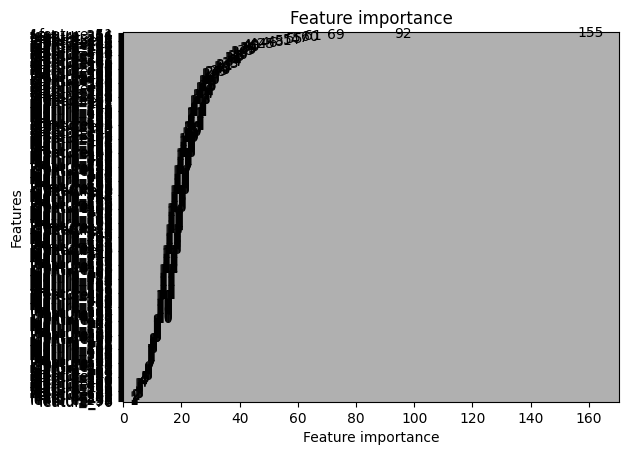

In [14]:
model = lgb.LGBMClassifier(**study.best_params, metric='auc', device='cpu', verbose=-1, n_jobs=-1, early_stopping_round=200)
model.fit(X, y, eval_set=(X_eval, y_eval), categorical_feature=list(cat_features))
lgb.plot_importance(model)

In [34]:
model.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8032017315773939)])})

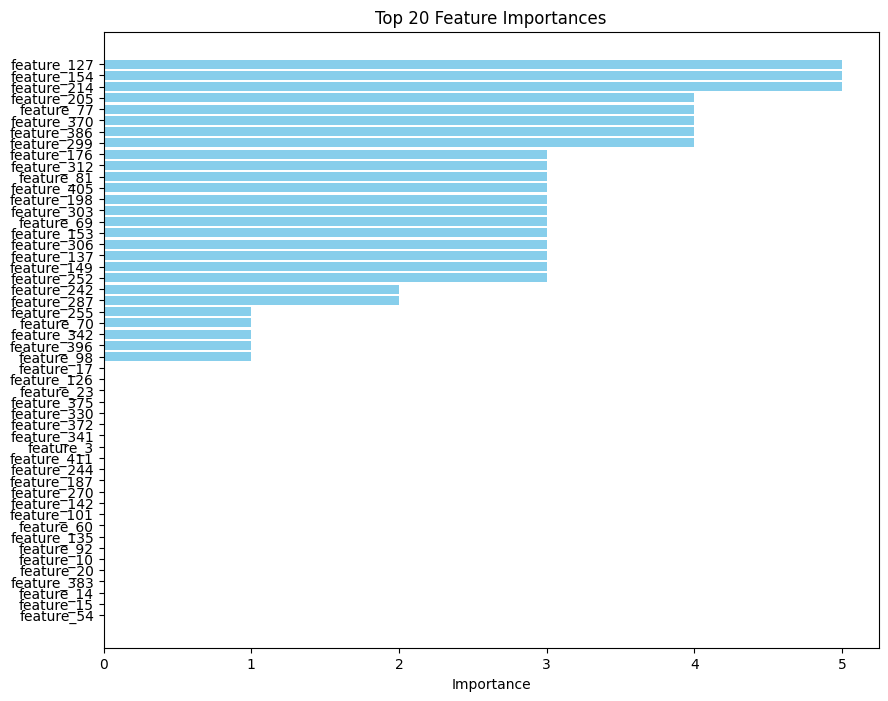

In [28]:
importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'][-50:], importance_df['Importance'][-50:], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

In [46]:
important_columns = importance_df[importance_df['Importance'] > 0]['Feature'].tolist()
important_columns

['feature_51',
 'feature_354',
 'feature_256',
 'feature_291',
 'feature_11',
 'feature_321',
 'feature_7',
 'feature_296',
 'feature_324',
 'feature_52',
 'feature_45',
 'feature_285',
 'feature_74',
 'feature_384',
 'feature_339',
 'feature_131',
 'feature_114',
 'feature_288',
 'feature_258',
 'feature_344',
 'feature_136',
 'feature_87',
 'feature_94',
 'feature_402',
 'feature_193',
 'feature_281',
 'feature_86',
 'feature_227',
 'feature_282',
 'feature_61',
 'feature_247',
 'feature_195',
 'feature_186',
 'feature_190',
 'feature_394',
 'feature_118',
 'feature_213',
 'feature_371',
 'feature_310',
 'feature_311',
 'feature_25',
 'feature_106',
 'feature_366',
 'feature_278',
 'feature_283',
 'feature_75',
 'feature_39',
 'feature_83',
 'feature_217',
 'feature_381',
 'feature_53',
 'feature_263',
 'feature_300',
 'feature_346',
 'feature_343',
 'feature_58',
 'feature_199',
 'feature_215',
 'feature_233',
 'feature_33',
 'feature_325',
 'feature_228',
 'feature_104',
 'feature_

In [47]:
X_important = X[important_columns]
X_eval_important = X_eval[important_columns]
categorical_important = [col for col in cat_features if col in important_columns]


In [48]:
model_imp = lgb.LGBMClassifier(**study.best_params, metric='auc', device='cpu', verbose=-1, n_jobs=-1, early_stopping_round=200)
model_imp.fit(X_important, y, eval_set=(X_eval_important, y_eval), categorical_feature=categorical_important)
model_imp.best_score_

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('auc', 0.8032017315773939)])})

# LightGBM submit ensemble

In [51]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42, )
models = []
avg_auc = []
for train_index, test_index in cv.split(X, y):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    model = lgb.LGBMClassifier(**study.best_params, metric='auc', device='cpu', verbose=-1, n_jobs=-1, early_stopping_round=200)
    model.fit(X_train_cv, y_train_cv, eval_set=(X_test_cv, y_test_cv), categorical_feature=list(cat_features))
    avg_auc.append(model.best_score_['valid_0']['auc'])
    print(sum(avg_auc) / len(avg_auc))
    models.append(model)

0.847798241698527
0.8117782909930716
0.798599924958436
0.7805792351582665
0.777738254310376
0.772989028260989
0.7714461280013712
0.7740073699587726
0.764623904207622
0.7694203466433626


In [56]:
models

[LGBMClassifier(device='cpu', early_stopping_round=200,
                learning_rate=0.020231285075910963, max_depth=24, metric='auc',
                min_child_samples=148, min_child_weight=2, n_estimators=402,
                n_jobs=-1, reg_alpha=0.504656746519248, verbose=-1),
 LGBMClassifier(device='cpu', early_stopping_round=200,
                learning_rate=0.020231285075910963, max_depth=24, metric='auc',
                min_child_samples=148, min_child_weight=2, n_estimators=402,
                n_jobs=-1, reg_alpha=0.504656746519248, verbose=-1),
 LGBMClassifier(device='cpu', early_stopping_round=200,
                learning_rate=0.020231285075910963, max_depth=24, metric='auc',
                min_child_samples=148, min_child_weight=2, n_estimators=402,
                n_jobs=-1, reg_alpha=0.504656746519248, verbose=-1),
 LGBMClassifier(device='cpu', early_stopping_round=200,
                learning_rate=0.020231285075910963, max_depth=24, metric='auc',
                mi

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
ensemble_data = []
for model in models:
    ensemble_data.append(model.predict_proba(X)[:, 1])
ensemble_data = pd.DataFrame(np.array(ensemble_data).T)

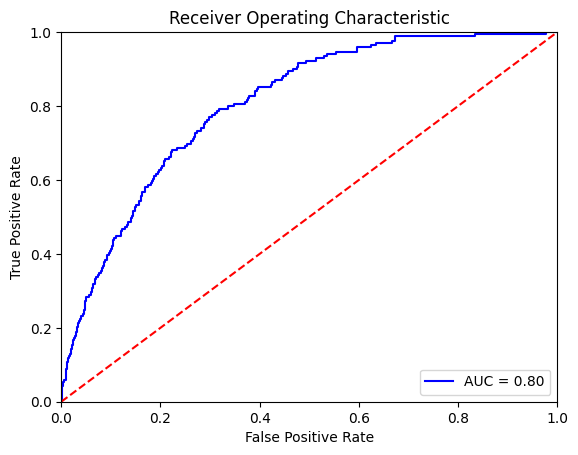

In [92]:
linear_model = LogisticRegression().fit(ensemble_data, y)
eval_data = []
for model in models:
    eval_data.append(model.predict_proba(X_eval)[:, 1])
eval_data = pd.DataFrame(np.array(eval_data).T)

final_preds = linear_model.predict_proba(eval_data)[:, 1]
fpr, tpr, threshold = roc_curve(y_eval, final_preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [88]:
X_test = X_test.drop(columns=['id'])

In [93]:
x_set = []
for model in models:
    x_set.append(model.predict_proba(X_test)[:, 1])
x_set = pd.DataFrame(np.array(x_set).T)
y_pred = linear_model.predict_proba(x_set)[:, 1]
y_pred = pd.DataFrame(y_pred)
y_pred['id'] = ids

In [ ]:
y_pred.columns = ['target', 'id']
y_pred = y_pred[['id', 'target']]
y_pred.to_csv('submission.csv', index=False)


In [ ]:
(y_pred.target > 0.5)

39